## Implement BTree Data Structure as a Key-Value Database

In this notebook I extend the BTree class developed through the DataQuest modulues in 'Recursion and Trees' modules into a key-value data structure to serve as a database object. In order to do so, a few modifications to the baseline BTree data structure need to be made to implement the `__getitem__()` and `__setitem__()` methods so that the BTree class behaves similar to a dictionary. In addition, functionality will be added to allow range queries to be made using numeric or string keys.

Once this is implemented, I will implement some simple functional and performance tests. The functional tests will be designed to ensure that the data structure is working correctly. The performance tests will access the performance of our key-value store by comparing it to Python dictionaries.

In [1]:
from btree import BTree

# declare key-value data base structure extending from BTree class
# the split threshold must be specified during initialization
class KVStore(BTree):
    def __init__(self, split_threshold):
        super().__init__(split_threshold)
    def add(self, key, value):
        # find node in tree, if none, use default add
        # otherwise, loop through keys in node and 
        # update value at the index corresponding to key
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key,value)
        else:
            for index, node_key in enumerate(node.keys): 
                if node_key == key:
                    node.values[index] = value

The BTree `add()` method allows multiple entries to be added with the same key. This is undesireable for a database structure and the above code defines a new `add()` method to overwrite this functionality. Specifically, if a key was already added, that node will be updated with the new value. Otherwise, the key-value pair will be added as usual. <br><br>

Before moving on, the current implementation will be tested to ensure that new values can be added and if keys are repeated, the values get replaced.

In [2]:
# test split threshold is properly implemented
kv = KVStore(2)
assert kv.split_threshold == 2, "The split threshold was not set to 2."

In [3]:
# test key-value pair can be added, retrieved and updated
k, v = 2, 5
kv.add(k,v)
assert kv.get_value(k) == v, "The inserted value should be {}.".format(v)

k, v2 = 2, 6
kv.add(k,v2)
assert kv.get_value(k) == v2, "The updated value is {} not {}".format(kv.get_value(k),v2)

Now that it has been verified that objects can be added and retrieved, let's make the KVStore structure easier to use by allowing the user to use bracket syntax to add and retrieve values.

In [4]:
class KVStore(BTree):
    def __init__(self, split_threshold):
        super().__init__(split_threshold)
    def add(self, key, value):
        # find node in tree, if none, use default add
        # otherwise, loop through keys in node and 
        # update value at the index corresponding to key
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key,value)
        else:
            for index, node_key in enumerate(node.keys): 
                if node_key == key:
                    node.values[index] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        return self.add(key,value)

Let's run the same tests as before to verify proper implementation of the methods:

In [5]:
# test key-value pair can be added, retrieved and updated
kv = KVStore(2)
kv[2] = 5
assert kv[2] == 5, "The inserted value was not retreived."

kv[2] = 6
assert kv[2] == 6, "The existing value for key was not updated properly."

Another nice feature to add is the `in` capability for dictionaries. To implement this the `__contains__()` method needs to be added to the custom class. This is already implemented in the `contains()` method in BTree, so this can be simply added as with `__setitem__()` and `__getitem__()`.

In [6]:
class KVStore(BTree):
    def __init__(self, split_threshold):
        super().__init__(split_threshold)
    def add(self, key, value):
        # find node in tree, if none, use default add
        # otherwise, loop through keys in node and 
        # update value at the index corresponding to key
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key,value)
        else:
            for index, node_key in enumerate(node.keys): 
                if node_key == key:
                    node.values[index] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        return self.add(key,value)
    
    def __contains__(self, key):
        return self.contains(key)

Let's test this implementation with both numeric and string keys (assuming all keys are of the same type):

In [7]:
# test 'in' method functionality
kv = KVStore(2)
# add key-value pairs to structure
for ch in 'abz':
    kv[ch] = ch

assert 'a' in kv, "The key 'a' is not in the kv structure."

kv = KVStore(2)
# add key-value pairs to structure
for n in [1,2,5,6,7]:
    kv[n] = n

assert 5 in kv, "The key '5' is not in the kv structure."

So far the KV data structure has the same functionality as a dictionary, with the exception that the datastructure maintains sorted order of the keys. As a database structure it would be beneficial to implement range queries. Lets implement a range query that returns all values for keys within a specified range (range_start:range_end). Moreover, I will add a function that checks/converts the keys and ranges to numerical values to accommodate keys that are of type string.

In [8]:
class KVStore(BTree):
    def __init__(self, split_threshold):
        super().__init__(split_threshold)
    def add(self, key, value):
        # find node in tree, if none, use default add
        # otherwise, loop through keys in node and 
        # update value at the index corresponding to key
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key,value)
        else:
            for index, node_key in enumerate(node.keys): 
                if node_key == key:
                    node.values[index] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        return self.add(key,value)
    
    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        # check if values need converting to numeric dtype
        range_start = self._convert_to_num(range_start)
        range_end = self._convert_to_num(range_end)
        min_key = self._convert_to_num(min_key)
        max_key = self._convert_to_num(max_key)

        # check if range start and end are in correct order
        if range_start > range_end:
            temp = range_start
            range_start = range_end
            range_end = temp

        if not self._range_intersect(range_start, range_end, min_key, max_key):
            return []
        
        results = []
        for i, key in enumerate(current_node.keys):
            key = self._convert_to_num(key)
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])

        # search recursively until leaf node found
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results
        
    # to make the implementation easier, reduce req'd var def to range_start and range_end 
    # auto set min and max keys to be +- inf (numeric equivalent)
    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))
    
    def _range_intersect(self, range_start, range_end, node_min, node_max):
        if not node_min is None and node_min > range_end:
            return False
        if not node_max is None and node_max < range_start:
            return False
        return True
        
    # check if key or range is str and convert to number
    def _convert_to_num(self, var):
        if type(var) == str:
            result = 0
            for c in var:
                result += ord(c)
            return result
        else:
            return var

The `new_key_min` and `new_key_max` is used to keep track of the range of values that the nodes can fall within. As soon as the range of values we wish to return falls outside of this, we stop searching on that subtree. An example is shown in the figure below from the DataQuest guided project 'creating and index for csv file':

** add figure once in jupyter notebook

Now the key-value data structure has been fully implemented. It is now important to test the full implementation. To do this, I will test the KVStore class against a standard dictionary. The implementation of a key-value store that uses a dictionary as the base data structure is as follows:

In [9]:
class DictKVStore(dict):
    # define range query on keys in dictionary
    def range_query(self, range_start, range_end):
        result = []
        range_start = self._convert_to_num(range_start)
        range_end = self._convert_to_num(range_end)
        for key in self.keys():
            key_c = self._convert_to_num(key)
            if range_start <= key_c and key_c <= range_end:
                result.append(self[key])
        return result
    
    def _convert_to_num(self, var):
        if type(var) == str:
            result = 0
            for c in var:
                result += ord(c)
            return result
        else:
            return var

Now we should be able to test that the KVStore class returns the expected range queries for the DictKVStore class.

In [10]:
# define instances of DictKVStore and KVStore
dict_kv = DictKVStore()
my_kv = KVStore(2)

# add values to the dictionary: value = key
for i in 'abcdefghij':
    dict_kv[i] = i
    my_kv[i] = i
    
# test for different ranges - sort since order not enforced in BTree
for range_start, range_end in [('a','b'), ('a','d'), ('c','e'), ('a','d')]:#[(1,3), (4,6), (1,10), (5,5)]:
    dict_result = sorted(dict_kv.range_query(range_start, range_end))
    print(dict_result)
    my_result = sorted(my_kv.range_query(range_start, range_end))
    print(my_result)
    assert dict_result == my_result, 'Returned range queries are not equivalent.'
 
# check numerical keys
dict_kv = DictKVStore()
my_kv = KVStore(2)
for i in range(10):
    dict_kv[i] = i
    my_kv[i] = i
    
for range_start, range_end in [(1,3), (4,6), (1,10), (5,5)]:
    dict_result = sorted(dict_kv.range_query(range_start, range_end))
    print(dict_result)
    my_result = sorted(my_kv.range_query(range_start, range_end))
    print(my_result)
    assert dict_result == my_result, 'Returned range queries are not equivalent.'

['a', 'b']
['a', 'b']
['a', 'b', 'c', 'd']
['a', 'b', 'c', 'd']
['c', 'd', 'e']
['c', 'd', 'e']
['a', 'b', 'c', 'd']
['a', 'b', 'c', 'd']
[1, 2, 3]
[1, 2, 3]
[4, 5, 6]
[4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[5]
[5]


Finally, let's check the performance of the BTree key-value data structure compared to the dictionary-based class. For this I will generate many entries and many query intervals. The time to retrieve the keys within the range will be compared for both data structures and the retrieval time plotted against query range length.

In [11]:
import timeit
import matplotlib.pyplot as plt
import numpy as np
import random
import csv

# generate many entries in each data structure
N = 50000

dict_kv = DictKVStore()
my_kv = KVStore(2)

for i in range(N):
    key = random.randint(0, N)
    value = random.randint(0, N)
    dict_kv[key] = value
    my_kv[key] = value

# define arrays to keep runtime for range queries in each structure
runtime_ratios = []

count = 0
print('First five range queries (start, end):')
with open('queries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        range_start = int(row[0])
        range_end = int(row[1])
        if count <= 5:
            print(range_start,',', range_end)
        
        # query dictionary structure - record execution time
        start = timeit.default_timer()
        query_dict = dict_kv.range_query(range_start, range_end)
        end = timeit.default_timer()
        runtime_dict = end-start

        # repeat for KV BTree data structure
        start = timeit.default_timer()
        query_kv = my_kv.range_query(range_start, range_end)
        end = timeit.default_timer()
        runtime_kv = end-start

        # compute ratio between query times on both structures
        runtime_ratios.append(runtime_dict/runtime_kv)
        
        count += 1
        

First five range queries (start, end):
31244 , 31244
43736 , 43737
47449 , 47451
29828 , 29831
29593 , 29597
18638 , 18643


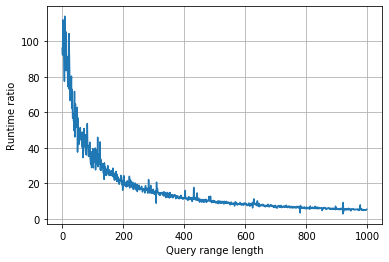

In [12]:
# plot runtime ratios verses query range
%matplotlib inline
plot_params = dict(linewidth = 0.5, color = '#581845', linestyle = '-')
grid_params = dict(linewidth = 0.5, color = '#E3E3E3', linestyle = '--', alpha = 0.5)

#plt.figure(figsize = (4,2))
plt.plot(runtime_ratios)#, **plot_params)
plt.xlabel('Query range length')
plt.ylabel('Runtime ratio')
plt.grid(True)#, **grid_params)
plt.show()


As we can see, when there are 50,000 entries in the dictionary, the BTree implementation offers a performance boost of approximately 100 times when the range query is small. As the query length gets longer the performance ratio approaches 1 as this becomes closer to searching all entries in the dictionary/tree.